### This notebook solves this kaggle [competetion](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) for classifing 6 categories of toxic comments with **accuracy 94.6%** according to the evaluation metric.

In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [79]:
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [82]:
# No Nulls

# check duplicates
df = df.drop(columns=['id'])
df.duplicated().sum()

0

In [83]:
# check data balance
df[df.columns[1:]].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

<AxesSubplot:>

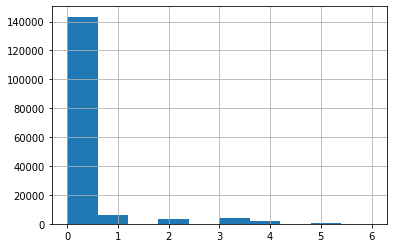

In [84]:
# show all frequencies
labels_freq = df[df.columns[1:]].sum(axis=1)
labels_freq.hist()

## First Note: The data is imbalanced.

# Text Preprocessing:

In [85]:
for text in df.sample(20)['comment_text']:
    print(text)

Arbitration: Konullu 

You have been mentioned here. Wikipedia:Arbitration/Requests/Enforcement
"

Lead
It was written and produced by Adam Messinger and Nasri of The Messengers and Sir Nolan, while Bieber and Ludacris, the song's guest feature, wrote additional lyrics. → It was written by Bieber, Sir Nolan and Nasri of The Messengers in collaboration with Ludacris, who guest features. 
but reached → reaching

Background and composition
while Bieber and Ludacris, the song's guest feature, wrote additional lyrics. → This is really unclear, it sounds like the are both features and that there is no lead artist. Apply what I suggested above.
I know Eurodance is sourced in the info box, but it seems strange not to include it in the Composition info?

Reception
I'd say from one of the first reviews, it is also a synth-pop song?
out of five stars, commented → out of five stars, and commented 
The chart performance section is tiny. Just from reading this, it sounds like it only charted in five

In [86]:
def to_lowercase(text):
    return text.lower()

# Remove website links
def remove_links(text):
    template = re.compile(r'https?://\S+|www\.\S+') 
    text = template.sub(r'', text)
    return text

# Remove HTML tags
def remove_html(text):
    template = re.compile(r'<[^>]*>') 
    text = template.sub(r'', text)
    return text

def text2words(text):
      return word_tokenize(text)

# Remove stopwords
def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]

# Remove none ascii characters
def remove_non_ascii(text):
    template = re.compile(r'[^\x00-\x7E]+') 
    text = template.sub(r'', text)
    return text

# Replace none printable characters
def remove_non_printable(text):
    template = re.compile(r'[\x00-\x0F]+') 
    text = template.sub(r' ', text)
    return text

# Remove special characters
def remove_special_chars(text):
    text = re.sub("'s", '', text)
    template = re.compile('["#$%&\'()\*\+-/:;<=>@\[\]\\\\^_`{|}~]') 
    text = template.sub(r'', text)
    return text

# Replace multiple punctuation 
def replace_multiplt_punc(text):
    text = re.sub('[.!?]{2,}', '.', text)
    text = re.sub(',+', ',', text) 
    return text


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


# Remove numbers
def remove_numbers(text):
    text = re.sub('\d+', '', text)
    return text


def handle_spaces(text):
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    # Remove spaces at the beginning and at the end of string
    text = text.strip() 
    return text


def lemmatize_words(words):
    """Lemmatize words in text"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]


def lemmatize_verbs(words):
    """Lemmatize verbs in text"""
    lemmatizer = WordNetLemmatizer()
    return ([lemmatizer.lemmatize(word, pos='v') for word in words])


def remove_pattern(text): 
    # remove hi moron 
    text= re.sub(r'(hi)(.*)\1', r'\1', text)
    # remove duplicate words
    text= re.sub(r"\b(\w+)(?:\W+\1\b)+",r'\1', text,flags=re.IGNORECASE)
    # remove [User:Cirt]] 
    text= re.sub(r"\[.*?\]", ' ', text)
    # remove \n\n
    text= re.sub(r"\n", ' ', text)
    return text


stop_words = set(stop_words)
def clean_text( text):
    text = remove_links(text)
    text = remove_html(text)
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_non_printable(text)
    text = remove_numbers(text)
    text = to_lowercase(text)
    text = remove_pattern(text)
    text = remove_punctuation(text)
    text = handle_spaces(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words) #either stem or lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)
    return ' '.join(words)

In [87]:
# test the result
sample_comments = df.sample(20)['comment_text']
result = sample_comments.apply(clean_text)

for text in result:
    print(text, '\n')

threat head observation pompous little goody goody expect kid glove treatment smell salt every turn usually retire open new account another name thank god im id mind little business stick little article stop run big strong men around place shoulder cry scent hanky cry sound like someone raise miss longfellow school young lady greatest challenge make french knot petit point pillow sham hahahahaha 

section keep undo everything could consider chat undo obviously bias cabal editor work include summerphd jeff g rolandr many others 

please vandalize page edit henry iv part continue block edit mz 

website youre cite british site british monarchy government site maintain british monarchy website canadian monarchy run canadian government name elizabeth ii queen canada website canadian governor general queen representative canada website governor general new zealand refer queen new zealand thip st vincent grenadine unique duty speak act queen st vincent grenadine queen unite kingdom 

mandodi

In [88]:
# clean the whole dataset
df['comment_text'] = df['comment_text'].apply(clean_text)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,daww match background colour im seemingly stic...,0,0,0,0,0,0
2,hey man im really try edit war guy constantly ...,0,0,0,0,0,0
3,cant make real suggestion improvement wonder s...,0,0,0,0,0,0
4,sir hero chance remember page,0,0,0,0,0,0


In [89]:
# check min & max comment length
lens = np.array([len(c.split(' ')) for c in df['comment_text']])
print('min length =', lens.min())
print('max length =', lens.max())

min length = 1
max length = 1250


(array([8.1507e+04, 4.2376e+04, 1.9336e+04, 7.6780e+03, 4.1520e+03,
        1.8560e+03, 1.0730e+03, 6.2200e+02, 3.4700e+02, 1.6500e+02,
        1.1900e+02, 6.3000e+01, 3.9000e+01, 2.2000e+01, 1.5000e+01,
        1.3000e+01, 1.7000e+01, 8.0000e+00, 1.1000e+01, 6.0000e+00,
        2.0000e+00, 5.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 8.0000e+00, 3.0000e+00,
        4.0000e+00, 1.0000e+00, 5.0000e+00, 7.0000e+00, 5.0000e+00,
        1.0000e+00, 9.0000e+00, 1.0000e+00, 6.0000e+00, 1.0000e+00,
        1.0000e+00, 3.0000e+00, 4.0000e+00, 1.0000e+00, 5.0000e+00,
        0.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.00

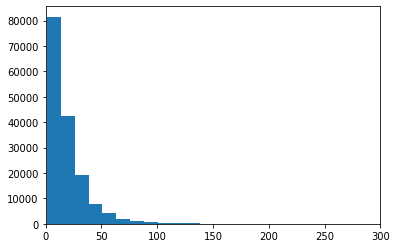

In [90]:
# show the whole distribution
plt.xlim((0, 300))
plt.hist(lens, bins=100)

In [91]:
len(lens[lens < 2])

1508

In [92]:
len(lens[lens > 150])

277

In [93]:
# Check if there are any special characteristics about those samples
def show_labels_distribution(indices):
    sample = df.loc[indices]
    plt.hist(sample[sample.columns[1:]].sum(axis=1))
    plt.show()

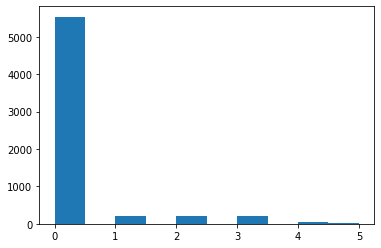

In [94]:
show_labels_distribution(lens < 3)

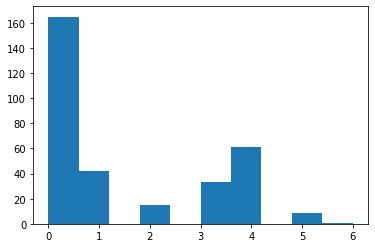

In [95]:
show_labels_distribution(lens > 140)

In [96]:
# Drop the samples with length < 3
# proper_lens = (lens > 2)
# df = df[proper_lens]
# df = df.reset_index()
# df.info()

In [97]:
df.loc[lens < 3]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
41,tfd thicagowpfour,0,0,0,0,0,0
74,whis well,0,0,0,0,0,0
89,thank read,0,0,0,0,0,0
137,imageyourtransitadjpg thing,0,0,0,0,0,0
138,cookie cookie,0,0,0,0,0,0
...,...,...,...,...,...,...,...
159472,ignore,0,0,0,0,0,0
159544,could worse,0,0,0,0,0,0
159547,thank much,0,0,0,0,0,0
159548,talkback september,0,0,0,0,0,0


# Model:

In [98]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(df, test_size=0.10, random_state=42)

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(train['comment_text'].values)

# Extract binary BoW features
x_train = tokenizer.texts_to_matrix(train['comment_text'].values, mode='tfidf')
x_dev = tokenizer.texts_to_matrix(dev['comment_text'].values, mode='tfidf')

# MAX_LEN = 150
# x_train = pad_sequences(x_train, padding='post', truncating='post', maxlen=MAX_LEN)
# x_dev = pad_sequences(x_dev, padding='post', truncating='post', maxlen=MAX_LEN)
print(x_train.shape)
print(x_dev.shape)

(143613, 1000)
(15958, 1000)


In [100]:
y_train = np.asarray(train[train.columns[1:]].values).astype('float32')
y_dev = np.asarray(dev[dev.columns[1:]].values).astype('float32')

In [101]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from sklearn.metrics import roc_auc_score


model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history = model.fit(x_train,
                    y_train,
                    epochs=16,
                    batch_size=512,
                    validation_data=(x_dev, y_dev))

y_pred = model.predict(x_dev)
roc_auc_score(y_dev, y_pred)

Epoch 1/16
281/281 [==============================] - 2s 5ms/step - loss: 0.1674 - binary_accuracy: 0.9529 - val_loss: 0.0765 - val_binary_accuracy: 0.9782
Epoch 2/16
281/281 [==============================] - 2s 7ms/step - loss: 0.0707 - binary_accuracy: 0.9788 - val_loss: 0.0672 - val_binary_accuracy: 0.9793
Epoch 3/16
281/281 [==============================] - 1s 5ms/step - loss: 0.0652 - binary_accuracy: 0.9793 - val_loss: 0.0654 - val_binary_accuracy: 0.9794
Epoch 4/16
281/281 [==============================] - 1s 5ms/step - loss: 0.0628 - binary_accuracy: 0.9797 - val_loss: 0.0644 - val_binary_accuracy: 0.9797
Epoch 5/16
281/281 [==============================] - 1s 4ms/step - loss: 0.0610 - binary_accuracy: 0.9800 - val_loss: 0.0640 - val_binary_accuracy: 0.9796
Epoch 6/16
281/281 [==============================] - 1s 5ms/step - loss: 0.0595 - binary_accuracy: 0.9804 - val_loss: 0.0640 - val_binary_accuracy: 0.9796
Epoch 7/16
281/281 [==============================] - 1s 5ms/ste

0.9504508890005979

In [102]:
from sklearn.metrics import f1_score
f1_score(y_dev[:, 0], y_pred[:, 0])
f1_score(y_dev, np.round(y_pred), average=None)

In [103]:
y_pred

array([[9.9022895e-02, 1.8180609e-03, 4.3311715e-02, 7.1278214e-04,
        1.4200807e-02, 3.5449862e-04],
       [1.3950467e-04, 6.8799044e-10, 3.5911833e-07, 6.8661299e-09,
        7.3461979e-07, 2.0443143e-09],
       [1.2247470e-01, 2.3311377e-04, 1.2225002e-02, 1.4248490e-04,
        3.7054807e-02, 1.5891492e-03],
       ...,
       [1.1703491e-02, 4.1762516e-05, 5.0069690e-03, 5.1900741e-05,
        4.1786134e-03, 1.2558699e-04],
       [3.8721308e-05, 4.2085966e-09, 4.0661358e-05, 2.1445108e-10,
        3.5486207e-07, 1.5779210e-11],
       [7.2140533e-01, 5.7512254e-02, 3.6449772e-01, 8.9571625e-02,
        1.7047125e-01, 3.5415709e-01]], dtype=float32)

In [104]:
test_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_df.head()


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [105]:
test_df['comment_text'] = test_df['comment_text'].apply(clean_text)
test_df.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful youll ever whats ha...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information update correct fo...
4,00017695ad8997eb,dont anonymously edit article


In [106]:
x_test = tokenizer.texts_to_matrix(test_df['comment_text'].values, mode='tfidf')
y_test = model.predict(x_test)

In [107]:
result_df = pd.DataFrame(data=y_test, columns=df.columns[1:])
df_sub = pd.concat([test_df, result_df], axis=1)
df_sub.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succesful youll ever whats ha...,0.993392,1.127429e-01,0.980034,1.254067e-02,7.605283e-01,1.569945e-02
1,0000247867823ef7,rfc title fine imo,0.000023,2.612152e-08,0.000001,3.398210e-07,4.842772e-07,1.890621e-08
2,00013b17ad220c46,source zawe ashton lapland,0.029046,7.559359e-04,0.010103,9.334385e-04,1.030165e-02,1.750678e-03
3,00017563c3f7919a,look back source information update correct fo...,0.000606,3.178848e-06,0.000037,2.677271e-05,1.393990e-05,4.365696e-06
4,00017695ad8997eb,dont anonymously edit article,0.068591,1.294792e-03,0.022030,1.747459e-03,2.152342e-02,3.249317e-03


In [108]:
df_sub = df_sub.drop(columns=['comment_text'])
df_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.993392,1.127429e-01,0.980034,1.254067e-02,7.605283e-01,1.569945e-02
1,0000247867823ef7,0.000023,2.612152e-08,0.000001,3.398210e-07,4.842772e-07,1.890621e-08
2,00013b17ad220c46,0.029046,7.559359e-04,0.010103,9.334385e-04,1.030165e-02,1.750678e-03
3,00017563c3f7919a,0.000606,3.178848e-06,0.000037,2.677271e-05,1.393990e-05,4.365696e-06
4,00017695ad8997eb,0.068591,1.294792e-03,0.022030,1.747459e-03,2.152342e-02,3.249317e-03


In [109]:
df_sub.to_csv('submission.csv', index=False)